In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("src/network.jl")
include("src/vsa.jl")
include("src/spiking.jl")

zero_nans (generic function with 1 method)

In [3]:
using NPZ

In [4]:
#x = random_symbols((100, 128));
#NPZ.npzwrite("inputs.npz", x)

In [5]:
x = NPZ.npzread("inputs.npz");

In [6]:
x |> size

(100, 128)

In [7]:
#model = Chain(PhasorDense(128 => 64), )
#NPZ.npzwrite("weights.npz", model[1].weight)

In [8]:
weights = NPZ.npzread("weights.npz")
model = Chain(PhasorDense(weights))

Chain(
  PhasorDense(128 => 64),               # 8_256 parameters
) 

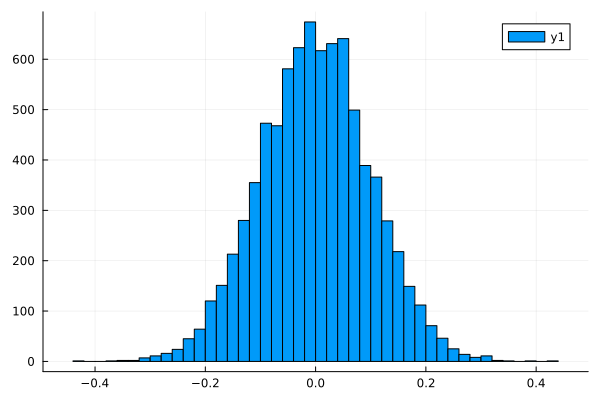

In [9]:
histogram(model[1].weight |> vec)

In [10]:
y = model(x);

In [11]:
#NPZ.npzwrite("static_y.npz", y)

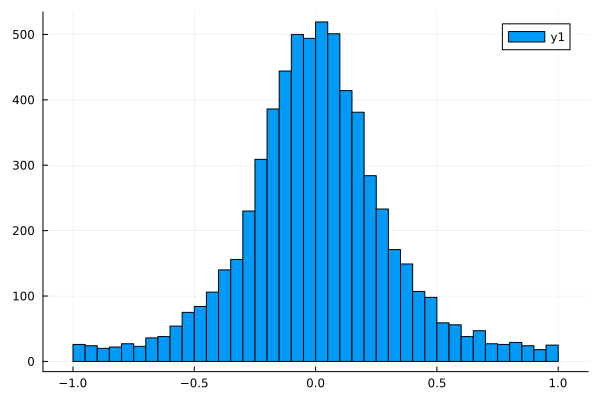

In [12]:
histogram(y |> vec)
#histogram!(y2 |> vec)

In [13]:
sa = SpikingArgs(2*pi, -0.2, 1.0, 0.03, 0.02, 0.01)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [14]:
xt = phase_to_train(x, sa, repeats = 10)

Spike Train: (100, 128) with 128000 spikes.

In [15]:
call = SpikingCall(xt, sa, (0.0, 20.0))

SpikingCall(Spike Train: (100, 128) with 128000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 20.0))

In [16]:
y_sol = model[1](call, return_solution=true);

In [17]:
using DataFrames

In [18]:
sa

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [19]:
currents = stack([spike_current(xt, t, sa) for t in 0.0:0.01:10.0])

100×128×1001 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0 

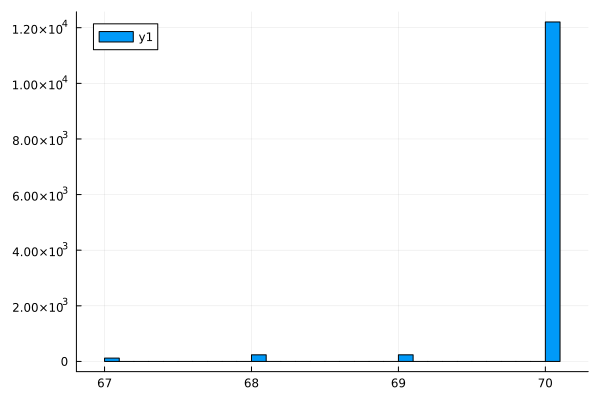

In [20]:
histogram(sum(currents, dims=3) |> vec)

In [21]:
NPZ.npzwrite("currents.npz", currents)

In [22]:
k = (sa.leakage + 1im * sa.angular_frequency)
u0 = zeros(ComplexF32, y |> size)
dzdt(u, t) = k .* u + spike_current(xt, t, sa) * model[1].weight' .+ bias_current(model[1].bias, t, 0.0, sa)'

dzdt (generic function with 1 method)

In [23]:
dzs = stack([dzdt(u0, t) for t in 0.0:0.01:10.0])

100×64×1001 Array{ComplexF64, 3}:
[:, :, 1] =
  0.0298855+0.0im   -0.049749+0.0im  …    0.083659+0.0im  -0.0838716+0.0im
  -0.350668+0.0im    0.131026+0.0im       0.454396+0.0im    0.257262+0.0im
   0.077821+0.0im   -0.166622+0.0im      -0.132398+0.0im   -0.158561+0.0im
  0.0121376+0.0im     0.14239+0.0im       0.486296+0.0im  -0.0491363+0.0im
  0.0849376+0.0im    0.201067+0.0im      -0.075794+0.0im   -0.217667+0.0im
    0.11766+0.0im  -0.0902292+0.0im  …   -0.220947+0.0im   -0.136302+0.0im
 -0.0396425+0.0im    0.324879+0.0im       0.466858+0.0im  -0.0652466+0.0im
   0.306683+0.0im  -0.0605255+0.0im      0.0540136+0.0im   -0.290904+0.0im
  0.0895255+0.0im    0.101932+0.0im     -0.0709097+0.0im   -0.137143+0.0im
   0.502295+0.0im   -0.347458+0.0im       0.761882+0.0im   -0.348799+0.0im
 0.00495531+0.0im  -0.0450336+0.0im  …   0.0909178+0.0im   -0.109853+0.0im
   -0.24235+0.0im    0.049985+0.0im     -0.0386978+0.0im  -0.0739721+0.0im
   0.156924+0.0im   -0.236911+0.0im      -0.262855+0.0

In [24]:
NPZ.npzwrite("dzs.npz", dzs)

In [25]:
all_u = stack(y_sol.u)

100×64×2001 Array{ComplexF32, 3}:
[:, :, 1] =
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                      

In [26]:
NPZ.npzwrite("solutions_real.npz", all_u)

In [27]:
y_spikes = find_spikes_rf(y_sol, call.spk_args)

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64), CartesianIndex(100, 64)], [0.2700000000000001, 0.6900000000000004, 1.6900000000000013, 2.6899999999999866, 3.699999999999965, 4.699999999999944, 5.699999999999923, 6.699999999999902, 7.69999999999988, 8.699999999999859  …  10.619999999999818, 11.639999999999796, 12.659999999999775, 13.669999999999753, 14.689999999999731, 15.69999999999971, 16.709999999999813, 17.71999999999997, 18.720000000000127, 19.720000000000283])

In [28]:
y_train  = SpikeTrain(y_spikes[1], y_spikes[2], size(y_sol.u[1]), 0.25)

Spike Train: (100, 64) with 130675 spikes.

In [29]:
y_call = SpikingCall(y_train, sa, (0.0, 20.0))

SpikingCall(Spike Train: (100, 64) with 130675 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 20.0))

In [30]:
y_sol.u[1] |> size

(100, 64)

In [31]:
function get_us(sol, idx)
    return mapreduce(x->getindex(x, idx), vcat, sol.u);
end

get_us (generic function with 1 method)

In [32]:
function get_tms_us(x, sol, u, index)
    inds = map(x-> x == index, x[1])
    tms = x[2][inds]
    u_inds = findall(vec(sum(sol.t .== tms', dims=2) .> 0))
    us = u[u_inds]
    return (tms, us)
end

get_tms_us (generic function with 1 method)

In [33]:
function generate_plot(sol, spikes, idx)
    u = get_us(sol, idx)
    tms, peaks = get_tms_us(spikes, sol, u, idx)

    fig = plot(sol.t, real.(u))
    plot!(sol.t, imag.(u))
    scatter!(tms, imag.(peaks))
    return fig
end

generate_plot (generic function with 1 method)

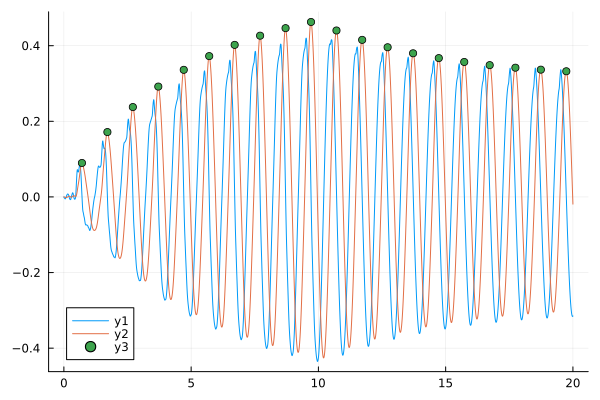

In [34]:
generate_plot(y_sol, y_spikes, CartesianIndex(100,1))

In [35]:
n1_u = get_us(y_sol, CartesianIndex(1,1))
n1_tms, n1_peaks = get_tms_us(y_spikes, y_sol, n1_u, CartesianIndex(1,1))

([0.2700000000000001, 0.6900000000000004, 1.6900000000000013, 2.6899999999999866, 3.699999999999965, 4.699999999999944, 5.699999999999923, 6.699999999999902, 7.69999999999988, 8.699999999999859  …  10.699999999999816, 11.709999999999795, 12.709999999999773, 13.719999999999752, 14.71999999999973, 15.729999999999709, 16.729999999999816, 17.729999999999972, 18.73000000000013, 19.730000000000285], ComplexF32[0.0011793582f0 + 0.03957685f0im, 0.0007889115f0 + 0.05174617f0im, 0.0077707306f0 + 0.14767458f0im, 0.016563384f0 + 0.22499946f0im, 0.0008744721f0 + 0.2885183f0im, 0.003063105f0 + 0.3405135f0im, 0.0046782615f0 + 0.38308218f0im, 0.005856086f0 + 0.41793254f0im, 0.0067020818f0 + 0.4464637f0im, 0.00729792f0 + 0.46982118f0im  …  0.031012485f0 + 0.5088687f0im, 0.013403593f0 + 0.47151846f0im, 0.025336491f0 + 0.4410565f0im, 0.00897172f0 + 0.41671678f0im, 0.018379387f0 + 0.39696524f0im, 0.0021628435f0 + 0.38095644f0im, 0.0093770055f0 + 0.36822912f0im, 0.015325355f0 + 0.3578355f0im, 0.016658502f0

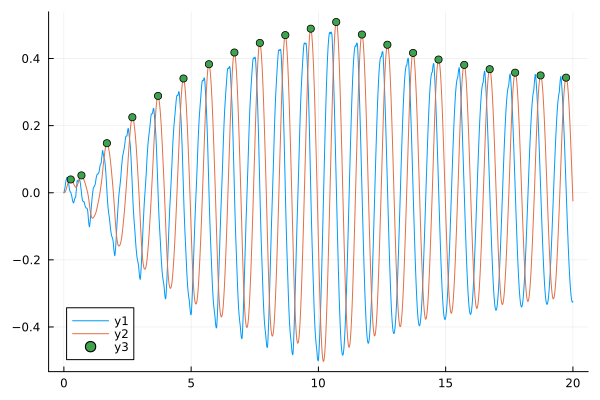

In [36]:
plot(y_sol.t, real.(n1_u))
plot!(y_sol.t, imag.(n1_u))
scatter!(n1_tms, imag.(n1_peaks))

In [37]:
n2_u = mapreduce(x->getindex(x, CartesianIndex(1,2)), vcat, y_sol.u);

In [38]:
n2_tms, n2_peaks = get_tms_us(y_spikes, y_sol, n2_u, CartesianIndex(1,2))

([0.7500000000000004, 1.8200000000000014, 2.8399999999999834, 3.8599999999999617, 4.859999999999941, 5.869999999999919, 6.869999999999898, 7.869999999999877, 8.869999999999855, 9.879999999999834, 10.849999999999813, 11.819999999999792, 12.799999999999772, 13.77999999999975, 14.76999999999973, 15.769999999999708, 16.75999999999982, 17.759999999999977, 18.760000000000133, 19.750000000000288], ComplexF32[0.002274809f0 + 0.039566383f0im, 0.0013653904f0 + 0.05404223f0im, 0.004120338f0 + 0.06980652f0im, 0.00038635748f0 + 0.08337957f0im, 0.0041489606f0 + 0.09475223f0im, 0.0011476267f0 + 0.10412974f0im, 0.0031166372f0 + 0.11189441f0im, 0.0047021005f0 + 0.118256964f0im, 0.0059782933f0 + 0.12347046f0im, 0.00043747842f0 + 0.12768836f0im, 0.0027582722f0 + 0.13653813f0im, 0.0005438057f0 + 0.16154705f0im, 0.00079858577f0 + 0.18577401f0im, 0.010288193f0 + 0.20728423f0im, 0.013033119f0 + 0.2256009f0im, 0.0045331772f0 + 0.24108537f0im, 0.013497309f0 + 0.2538937f0im, 0.008366244f0 + 0.26458585f0im, 0.00

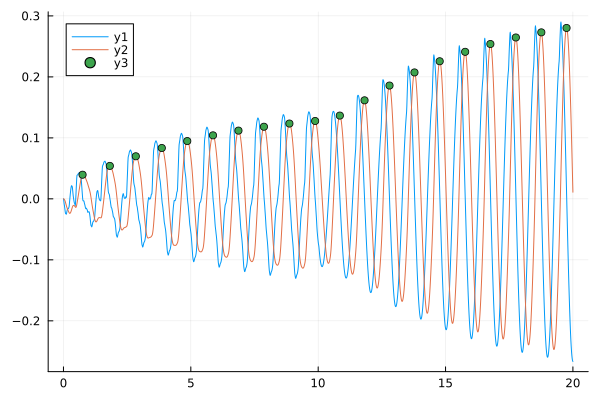

In [39]:
plot(y_sol.t, real.(n2_u))
plot!(y_sol.t, imag.(n2_u))
scatter!(n2_tms, imag.(n2_peaks))

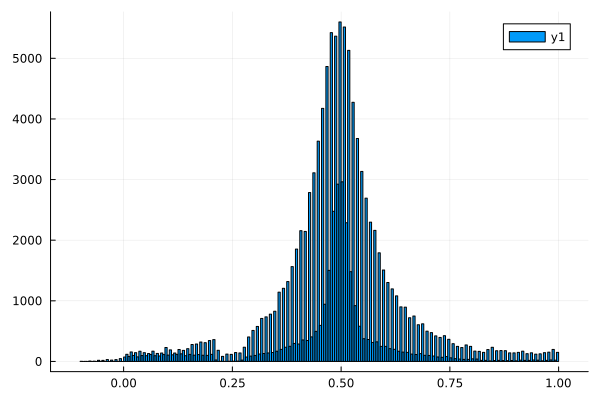

In [40]:
histogram((y_call.train.times .- y_call.train.offset) .% 1.0)


In [42]:
y_train.shape

(100, 64)

In [43]:
function train_to_phase_slow(train::SpikeTrain, spk_args::SpikingArgs)
    if length(train.times) == 0
        return missing
    end

    phases = Array{Vector{<:Real}}(undef, train.shape...)

    for i in 1:train.shape[1], j in 1:train.shape[2]
        idx = CartesianIndex(i, j)
        idx_matches = findall(map(x->x == idx, train.indices))
        times = train.times[idx_matches]
        idx_phases = time_to_phase(times, spk_args.t_period, train.offset)
        phases[i,j] = idx_phases
    end

    return phases



end

train_to_phase_slow (generic function with 1 method)

In [44]:
y_sphase = train_to_phase_slow(y_train, sa)

100×64 Matrix{Vector{<:Real}}:
 [-0.96, -0.12, -0.12, -0.12, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1  …  -0.1, -0.08, -0.08, -0.06, -0.06, -0.04, -0.04, -0.04, -0.04, -0.04]                                                                                                                      …  [-0.92, -0.22, -0.3, -0.3, -0.3, -0.32, -0.32, -0.32, -0.32, -0.32  …  -0.3, -0.26, -0.24, -0.2, -0.16, -0.14, -0.12, -0.1, -0.08, -0.08]
 [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.06, 0.06, 0.06, 0.04, 0.04, 0.04, 0.02, 0.02, 0.02]                                                                                                                                         [0.24, 0.24, 0.24, 0.24, 0.24, 0.26, 0.26, 0.26, 0.26, 0.26, 0.22, 0.18, 0.14, 0.12, 0.1, 0.08, 0.06, 0.06, 0.04, 0.02]
 [0.16, 0.22, 0.24, 0.26, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.22, 0.18, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02]                                                                           

In [45]:
using Statistics: median

In [46]:
function median_spike(x)
    try
        return median(x)
    catch
        return NaN32
    end
end

median_spike (generic function with 1 method)

In [47]:
y_sphase2 = map(median_spike, y_sphase);

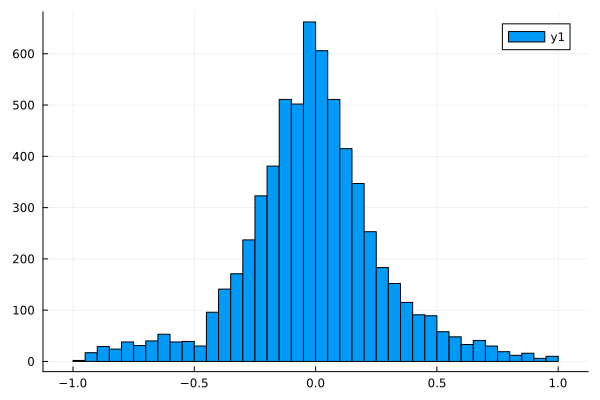

In [48]:
histogram(y_sphase2 |> vec)

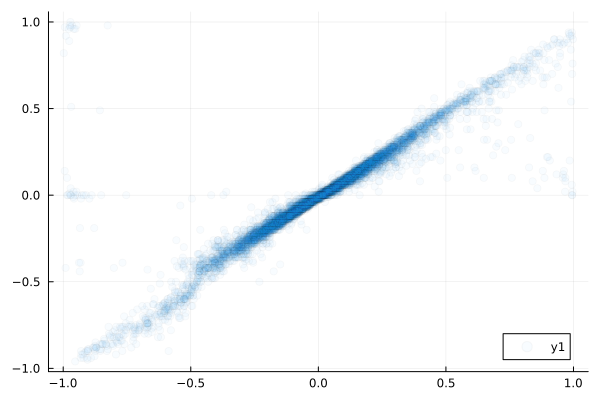

In [49]:
scatter(y |> vec, y_sphase2 |> vec, alpha = 0.03)

In [50]:
cyc4_err = y .- y_sphase2;

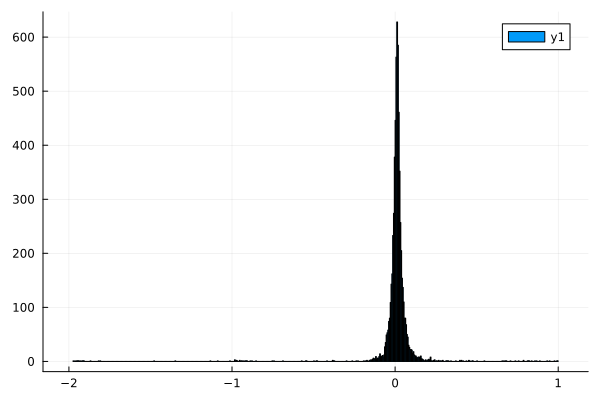

In [51]:
histogram(cyc4_err |> vec)

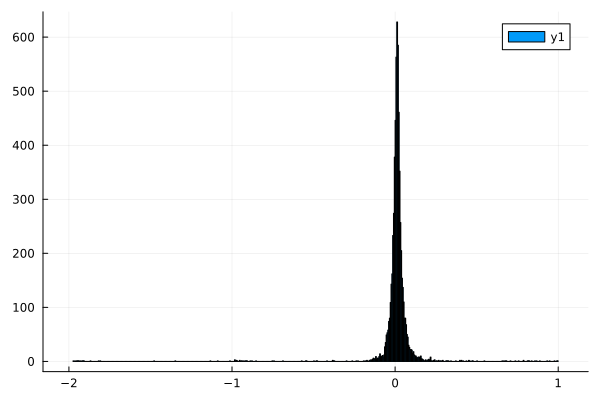

In [53]:
histogram(cyc4_err |> vec)

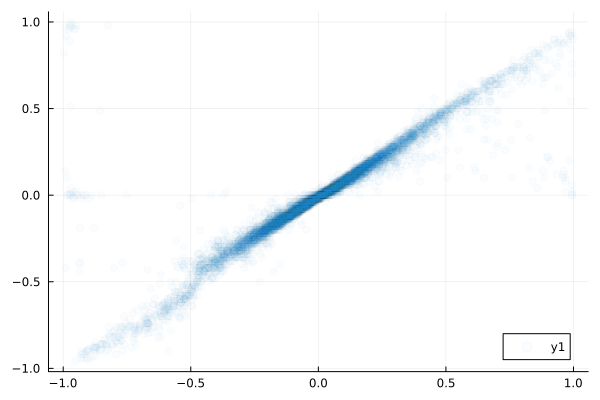

In [54]:
scatter(vec(y), vec(y_sphase2), alpha=0.02)

In [56]:
n_zeros = mapslices(x->sum(isnan.(x)), y_sphase, dims=(2,3)) |> vec

LoadError: BoundsError: attempt to access 2-element Vector{Any} at index [3]

In [ ]:
cv = cycle_correlation(y, y_sphase)

20-element Vector{Float64}:
 0.7212958834003148
 0.7845281277895019
 0.8069147455181284
 0.8146896765582169
 0.8257346798044672
 0.8299976415264035
 0.8333358589827716
 0.8333041333643525
 0.8482773735946914
 0.8421135485557772
 0.8401686217994558
 0.8408940663712859
 0.8410184105351228
 0.8430990889330835
 0.845181824368219
 0.849802383438664
 0.8558339101367813
 0.8637160414835381
 0.8738567930492659
 0.8970677984815385

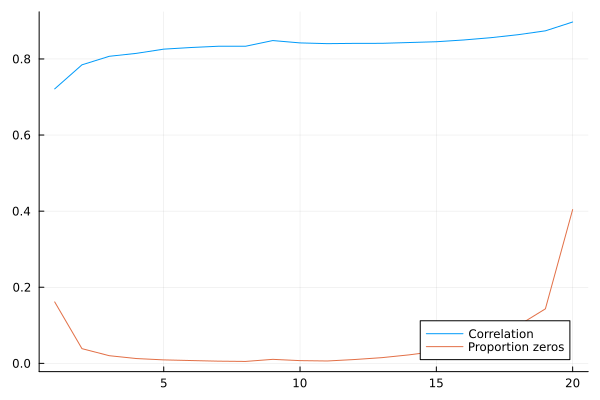

In [ ]:
plot(cv, label="Correlation")
plot!(n_zeros / prod(size(y_sphase[1,:,:])), label="Proportion zeros")

In [ ]:
function train_to_phase(train::SpikeTrain, spk_args::SpikingArgs)
    if length(train.times) == 0
        return missing
    end

    #decode each spike's phase within a cycle
    relative_phase = time_to_phase(train.times, spk_args.t_period, train.offset)
    relative_time = train.times .- train.offset
    relative_time = filter(x -> x > 0, relative_time)
    #what is the number of cycles in this train?
    n_cycles = mod(maximum(relative_time), spk_args.t_period) + 1
    #what is the cycle in which each spike occurs?
    cycle = floor.(Int, mod.(relative_time, spk_args.t_period) .+ 1)
    phases = [NaN .* zeros(train.shape...) for i in 1:n_cycles]

    for i in eachindex(relative_phase)
        phases[cycle[i]][train.indices[i]] = relative_phase[i]
    end

    #stack the arrays to cycle, batch, neuron
    phases = mapreduce(x->reshape(x, 1, train.shape...), vcat, phases)
    return phases

end

train_to_phase (generic function with 2 methods)